In [3]:
%matplotlib inline
#%pdb
from astropy.io import votable as vo
from astropy.io import ascii, fits
import aplpy as ap
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import os
import time
from astropy import units as u
import astropy.coordinates as coords
import scipy
from scipy import ndimage
import re
import pyregion
import shutil
#import montage_wrapper as mt
from astropy.table import Table, Column, vstack, join
from scipy.optimize import curve_fit
from IPython.display import clear_output
from spectral_cube import SpectralCube as sc
from scipy.ndimage import rotate
import pyspeckit
from lmfit.models import GaussianModel, LinearModel
import matplotlib.patheffects as path_effects

mpl.rc("font", family="serif", size=15, weight=2)
mpl.rc("axes", linewidth = 2.0)
mpl.rc("lines", linewidth = 1.0)
mpl.rc("xtick.major", pad = 5, width = 1)
mpl.rc("ytick.major", pad = 5, width = 1)
mpl.rc("xtick.minor", width = 1)
mpl.rc("ytick.minor", width = 1)
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

import astropy.units as u
from spectral_cube import SpectralCube as Spcube
import numpy as np
from pvextractor import Path
from scipy.optimize import curve_fit

In [8]:
extinmap = 'ExtinMap/im_fits/taurus/'
sour_name = 'taurus'
extinpdf = 'extinPDF/'

In [56]:
pdf_data = 0
pdf_fit = 1

hdu = fits.open(extinmap+sour_name+'_extin.fits')
data = hdu[0].data
for reg in ['reg1','reg2','reg3','reg4']:
    if (reg=='reg1'):
        bcx,bcy,bwx,bwy=296,216,92,74
        dataNew = data[bcy-bwy/2:bcy+bwy/2,bcx-bwx/2:bcx+bwx/2]
    elif (reg=='reg2'):
        bcx,bcy,bwx,bwy=242,160,94,62
        dataNew = data[bcy-bwy/2:bcy+bwy/2,bcx-bwx/2:bcx+bwx/2]
    elif (reg=='reg3'):
        bcx,bcy,bwx,bwy=157,144,122,92
        dataNew = data[bcy-bwy/2:bcy+bwy/2,bcx-bwx/2:bcx+bwx/2]
    elif (reg=='reg4'):
        bcx,bcy,bwx,bwy=208,87,162,64
        dataNew = data[bcy-bwy/2:bcy+bwy/2,bcx-bwx/2:bcx+bwx/2]
    
    FlatData = dataNew.flat
    arrData = np.array(FlatData)
    tbl = Table([arrData])
    tbl['col0'].name = 'AV'
    tbl.write(extinpdf+reg+'_pdf_para.tbl',format = 'ascii.fixed_width',
    formats = {'AV':'%8.3e'}, delimiter=None,overwrite=True)


using a non-integer number instead of an integer will result in an error in the future
using a non-integer number instead of an integer will result in an error in the future
using a non-integer number instead of an integer will result in an error in the future
using a non-integer number instead of an integer will result in an error in the future


alpha = 1.52


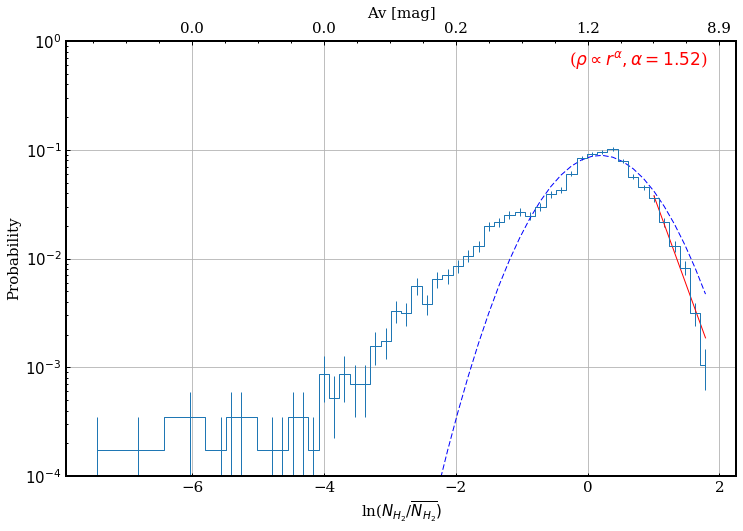

In [65]:
from lmfit import  Model
Mean_env = 1.2*0.94e21 # conversion from Av to NH2
for reg in ['reg2']:
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = fig.add_subplot(111)
    ax1.minorticks_on()
    ax2 = ax1.twiny()
    ax2.minorticks_on()
    figname = extinpdf+reg+'_pdf.eps'
    data = ascii.read(extinpdf+reg+'_pdf_para.tbl')
    dat = data['AV'].data*0.94e21
    index = np.where(dat>0)
    x = dat[index]
    x = np.array(np.log(x/Mean_env))
    print (len(x))
    bin_numb = 60
    numb, bin_edges, patches = ax1.hist(x, 
        bins=bin_numb, edgecolor='black', facecolor = 'gray',
        alpha = 1,normed=False)

    #the errors derived from the poisson distribution
    numb_err =  np.sqrt(numb)

    #determing the fraction of the number within each bin
    frac = numb/np.sum(numb)
    frac_err = numb_err/np.sum(numb)

    #determing the bin center
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    
    #ensuring the value at each bin above 0
    index = np.where((frac>0) & (frac<1))
    frac = frac[index]
    frac_err = frac_err[index]
    bin_all=np.array(bin_centers)
    bin_all= bin_all[index]
    
    ax1.clear()
    ax1.set_yscale('log')
    #ax1.set_xlim(-3.0,3.5)
    #ax1.set_ylim(1e-6,1.0)
    #print bin_all, frac
    #ax1.plot(bin_all,frac)
    ax1.errorbar(bin_all,frac,frac_err,drawstyle='steps-mid')#,label=label
    #legend = plt.legend(loc='upper right', shadow=False, fontsize='large')
    #plt.tick_params(axis = 'both', which = 'major' ,length = 10, width = 2,size = 14)
    #plt.tick_params(axis = 'both', which = 'minor' ,length = 5, width = 2, size = 7)
    

    def tick_function(var):
        AV = np.exp(var)*Mean_env/0.94e21   # Bohlin et al. (1978)
        return ["%.1f" % z for z in AV]
    #bin_NH2 = np.exp(bin_all)*Mean_env

    ax1Ticks = ax1.get_xticks()   
    ax2Ticks = ax1Ticks
    ax2.set_xticks(ax2Ticks)
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels(tick_function(ax2Ticks))
    ax2.set_xlabel('Av [mag]')
    ax1.grid(True)

    #do log-normal fit
    # determin the bin range with log normal distriution
    index =  np.where(bin_all<=1.0)
    bin_logn = bin_all[index]
    frac_logn = frac[index]
    ferr_logn = frac_err[index]
    
    #single-peaked lognormal expreasion
    def logpdf_1peak(x, p1,mu1, sigma1):
        a1 = p1/(sigma1*np.sqrt(2*np.pi) )
        b1 = -(x-mu1)**2/(2*sigma1**2)
        p = a1*np.exp(b1)
        return p
    
    p1 = frac_logn.max()
    mu1 = bin_logn[np.where(frac_logn==p1)]
    mu1 = mu1[0]
    sigma1 = 0.01
    fmodel = Model(logpdf_1peak)
    pars = fmodel.make_params()
    pars['p1'].set(p1,min=0.0,max=1.0)
    pars['mu1'].set(mu1,min=0,max=1)
    pars['sigma1'].set(sigma1,min=0.0)
   
#   #init = fmodel.eval(pars,x=xx)
    result = fmodel.fit(frac_logn,pars,x=bin_logn,p1=p1,mu1=mu1,sigma1=sigma1)   
    print(result.fit_report())
   
   
#     #plt.plot(xx, result.init_fit, 'k--')
    #ax1.plot(bin_logn, result.best_fit, 'blue',linewidth=1)
    #plot the fitting 
    yfit1p_I = logpdf_1peak(bin_all,result.params['p1'].value,result.params['mu1'].value,result.params['sigma1'].value)
    ax1.plot(bin_all,yfit1p_I,'b--')

    #plt.show()
    #ax.xlabel(r'$\phi$')
    #ax.ylabel('$SF_{L}(\phi)$')
    ax1.set_ylim(10e-5,1)
    xmin,xmax = ax1.get_xlim()
    ymin,ymax = ax1.get_ylim()   
    #ax.tick_params(axis = 'both', which = 'major' ,length = 10, width = 1)
    #ax.tick_params(axis = 'both', which = 'minor' ,length = 5, width = 1)
    
    ax1.set_xlabel(r'ln'+r'($N_{H_{2}}$/$\overline{N_{H_{2}}})$')
    ax1.set_ylabel('Probability')

    #do powerlaw fit
    #determine the bin range following the power law
    index =  np.where((bin_all>=1.0))#&(bin_all<=2.2)
    bin_pl = bin_all[index]
    frac_pl = frac[index]
    ferr_pl = frac_err[index]

    #define the powler law expression, referting to Tremblin et al. 2014, A&A, 564, A106
    def pl_func(x, a,n):
        pl = a*np.exp(n*x)
        return pl

    p, cov = curve_fit(pl_func, bin_pl, frac_pl,p0=None,sigma=ferr_pl,maxfev = 10000)
    yfit_pl = pl_func(bin_pl,p[0],p[1])
    
    ax1.plot(bin_pl,yfit_pl,'r-')
    
    fig.savefig(figname,bbox_inches = 'tight',papertype='a2')
    clear_output()
    print ("alpha = %4.2f"%(-2.0/p[1]+1.0))
    label = r'($\rho\propto r^{\alpha},\alpha=%.2f$)'%(-2.0/p[1]+1.0)
    plt.text(xmax-(xmax-xmin)*0.25, 
            ymax-(ymax-ymin)*0.40, label,
            horizontalalignment='left',size = 17,color='red')
    #fig.clear()